In [1]:
import json
from openai import OpenAI

with open("openai/api_key.txt") as f:
    api_key = f.read().strip()

### LLM

In [2]:
with open("results/iupacs_saliency_map.json", "r") as f:
    iupacs_saliency_map = json.load(f)

with open("results/iupacs_grad_cam.json", "r") as f:
    iupacs_grad_cam = json.load(f)

In [3]:
grad_cam_results = {}
saliency_map_results = {}

In [4]:
prompt_targets = {
    "herg": "HERG toxicity",
    "pampa": "PAMPA permeability",
    "cyp": "CYP3A4 inhibition"
}

for dataset_name in ("herg", "pampa", "cyp"):
    total_result = []
    for i in range(len(iupacs_grad_cam[dataset_name])):
        result = []
        for iupac in iupacs_grad_cam[dataset_name][i]:
            client = OpenAI(api_key=api_key)
            completion = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {
                        "role": "system",
                        "content": "You are a helpful assistant."
                    },
                    {
                        "role": "user",
                        "content": f"""
                        Rate the molecule fragment with the IUPAC name: {iupac} with respect to its impact on the {prompt_targets[dataset_name]}.
                        Output an integer score between 1 and 10, where 1 means the component has a very low impact on the {prompt_targets[dataset_name]}
                        and 10 means the component has a very high impact on the {prompt_targets[dataset_name]}.
                        Do not output anything besides the score.
                        """
                    }
                ]
            )
            result.append(completion.choices[0].message.content)
        total_result.append(result)
    grad_cam_results[dataset_name] = total_result

for dataset_name in ("herg", "pampa", "cyp"):
    total_result = []
    for i in range(len(iupacs_saliency_map[dataset_name])):
        result = []
        for iupac in iupacs_saliency_map[dataset_name][i]:
            client = OpenAI(api_key=api_key)
            completion = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {
                        "role": "system",
                        "content": "You are a helpful assistant."
                    },
                    {
                        "role": "user",
                        "content": f"""
                        Rate the molecule fragment with the IUPAC name: {iupac} with respect to its impact on the {prompt_targets[dataset_name]}.
                        Output an integer score between 1 and 10, where 1 means the component has a very low impact on the {prompt_targets[dataset_name]}
                        and 10 means the component has a very high impact on the {prompt_targets[dataset_name]}.
                        Do not output anything besides the score.
                        """
                    }
                ]
            )
            result.append(completion.choices[0].message.content)
        total_result.append(result)
    saliency_map_results[dataset_name] = total_result

In [5]:
with open("results/llm_grad_cam_results.json", "w") as f:
    json.dump(grad_cam_results, f)

with open("results/llm_saliency_map_results.json", "w") as f:
    json.dump(saliency_map_results, f)

### Loading results and making plots

In [6]:
with open("results/llm_grad_cam_results.json", "r") as f:
    grad_cam_results = json.load(f)

with open("results/llm_saliency_map_results.json", "r") as f:
    saliency_map_results = json.load(f)

In [7]:
grad_cam_results

{'herg': [['1', '4', '1', '4', '2', '3', '5', '2', '3', '5'],
  ['1', '2', '5', '5', '5', '2', '2', '3', '2', '4'],
  ['1', '5', '2', '2', '3', '7', '3', '1', '5', '2'],
  ['1', '5', '3', '3', '5', '4', '7', '4', '2', '2'],
  ['1', '2', '5', '3', '3', '3', '5', '3', '3', '3'],
  ['1', '3', '3', '3', '3', '2', '3', '3', '3']],
 'pampa': [['3', '4', '4', '6', '3', '8', '3', '4', '3', '3'],
  ['7', '5', '6', '8', '6', '3', '5', '4', '3', '4'],
  ['6', '4', '8', '8', '3', '7', '9', '3', '5', '7'],
  ['5', '4', '7', '6', '6', '3', '3', '3', '2', '5'],
  ['6', '7', '2', '7', '6', '5', '4', '2', '3', '5'],
  ['4', '6', '5', '5', '4', '5', '8', '3', '5']],
 'cyp': [['1', '2', '2', '2', '2', '2', '1', '1', '4', '3'],
  ['1', '2', '3', '4', '4', '4', '2', '3', '5', '2'],
  ['1', '2', '4', '1', '2', '3', '4', '3', '2', '4'],
  ['1', '3', '3', '3', '3', '2', '3', '2', '3', '2'],
  ['1', '3', '3', '4', '3', '3', '2', '3', '2', '3'],
  ['1', '2', '2', '3', '5', '4', '3', '4', '4', '3']]}

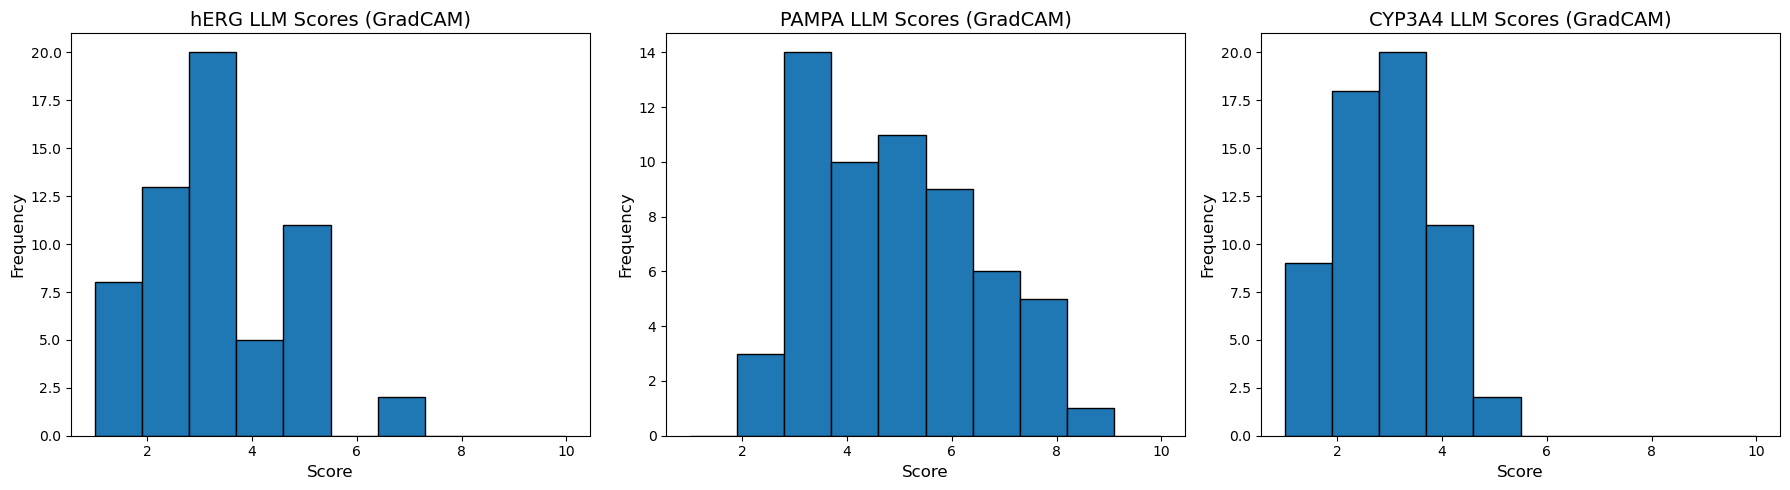

In [20]:
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

dataset_name_mapping = {
    "herg": "hERG",
    "pampa": "PAMPA",
    "cyp": "CYP3A4"
}

# Plot histograms for each dataset
datasets = ['herg', 'pampa', 'cyp']
for ax, dataset in zip(axes, datasets):
    scores = [int(score) for sublist in grad_cam_results[dataset] for score in sublist]
    ax.hist(scores, bins=10, range=(1, 10), edgecolor='black')
    ax.set_title(f'{dataset_name_mapping[dataset]} LLM Scores (GradCAM)', fontsize=14)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig("results/llm_grad_cam_scores.png")
plt.show()

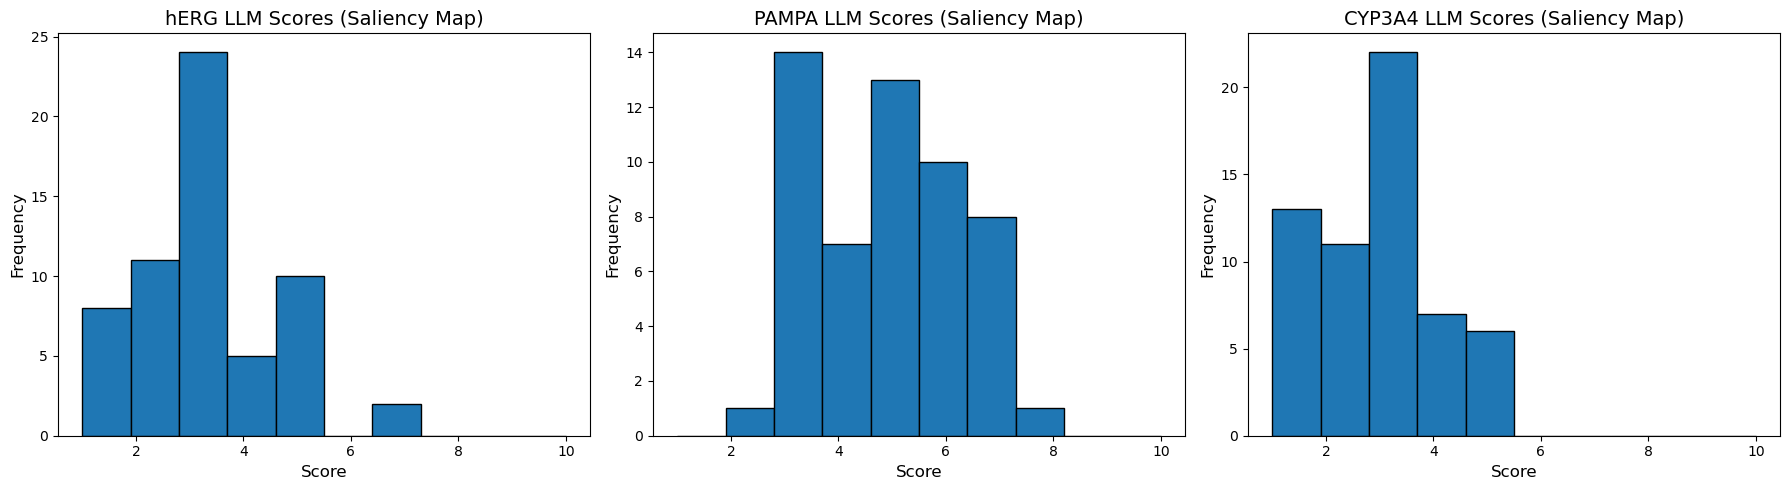

In [21]:
# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot histograms for each dataset
datasets = ['herg', 'pampa', 'cyp']
for ax, dataset in zip(axes, datasets):
    scores = [int(score) for sublist in saliency_map_results[dataset] for score in sublist]
    ax.hist(scores, bins=10, range=(1, 10), edgecolor='black')
    ax.set_title(f'{dataset_name_mapping[dataset]} LLM Scores (Saliency Map)', fontsize=14)
    ax.set_xlabel('Score', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)

# Adjust layout
plt.tight_layout()
plt.savefig("results/llm_saliency_map_scores.png")
plt.show()